In [33]:
# Установка необходимых библиотек
# !pip install transformers datasets evaluate scikit-learn matplotlib seaborn
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers datasets evaluate
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers[torch] accelerate>=0.26.0
!pip install transformers[torch]



In [34]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset

sns.set(style='whitegrid')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)


Используемое устройство: cpu


In [35]:
# Загрузка и подготовка данных
df = pd.read_csv("processed_data_new.csv")
target_columns = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Ничего из перечисленного"
]
text_column = "comment"
df[text_column] = df[text_column].fillna("")

X_train, X_test, y_train, y_test = train_test_split(df[text_column], df[target_columns], test_size=0.2, random_state=42)
train_df = pd.DataFrame({text_column: X_train, **{col: y_train[col].values for col in target_columns}})
test_df = pd.DataFrame({text_column: X_test, **{col: y_test[col].values for col in target_columns}})


In [36]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example[text_column], truncation=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map: 100%|██████████| 373/373 [00:00<00:00, 19636.70 examples/s]


In [37]:
# 1) Переименование колонок, как раньше
rename_mapping = {col: f"label_{i}" for i, col in enumerate(target_columns)}
train_dataset = train_dataset.rename_columns(rename_mapping)
test_dataset  = test_dataset.rename_columns(rename_mapping)

# 2) Объединяем в labels и сразу конвертируем в float
label_cols = list(rename_mapping.values())

def combine_labels(example):
    # собираем список float-меток
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_dataset = train_dataset.map(
    combine_labels,
    remove_columns=label_cols,
)

test_dataset = test_dataset.map(
    combine_labels,
    remove_columns=label_cols,
)

# 3) Форматируем в torch
train_dataset = train_dataset.with_format("torch")
test_dataset  = test_dataset.with_format("torch")

# 4) Настройка Trainer как раньше
args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Map: 100%|██████████| 373/373 [00:00<00:00, 7764.45 examples/s]
C:\Users\Vlad\AppData\Local\Temp\ipykernel_17336\4258683688.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [38]:
trainer.train()

f:\GIT HUB PROJECTS\intensive_4\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.535500
100,0.458500
150,0.409600
200,0.385800
250,0.358600
300,0.333700
350,0.324200


TrainOutput(global_step=374, training_loss=0.39805987811981036, metrics={'train_runtime': 595.7549, 'train_samples_per_second': 4.999, 'train_steps_per_second': 0.628, 'total_flos': 75539747768112.0, 'train_loss': 0.39805987811981036, 'epoch': 2.0})

f:\GIT HUB PROJECTS\intensive_4\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


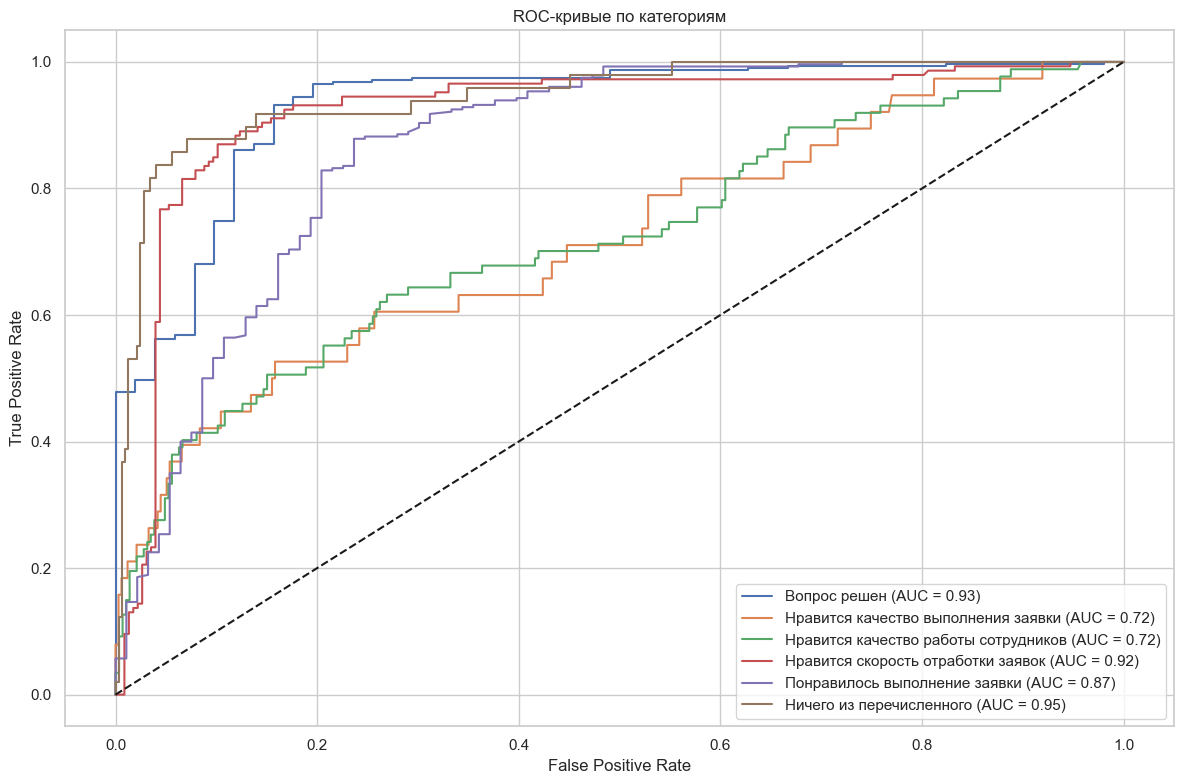


R² (коэффициент детерминации): 0.35996556282043457


In [39]:
raw_pred, _, _ = trainer.predict(test_dataset)
probs = torch.sigmoid(torch.tensor(raw_pred)).numpy()
y_true = y_test[target_columns].values
y_pred_bin = (probs >= 0.5).astype(int)

# ROC-кривые
plt.figure(figsize=(12, 8))
roc_scores = {}
for i, label in enumerate(target_columns):
    if len(np.unique(y_true[:, i])) > 1:
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        score = roc_auc_score(y_true[:, i], probs[:, i])
        roc_scores[label] = score
        plt.plot(fpr, tpr, label=f"{label} (AUC = {score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по категориям")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# R2
print("\nR² (коэффициент детерминации):", r2_score(y_true, probs))
